<a href="https://colab.research.google.com/github/cyuancheng/Stock_Prediction/blob/master/ETF_TimeSeries_TradingSignal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ETF trading signal testing

In [0]:
import datetime as dt
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [5]:
# set start and end date
start_date = dt.datetime(2000, 1, 1)
end_date = dt.datetime.now()

# read qqq data from Yahoo api
df = web.DataReader('qqq', 'yahoo', start_date, end_date)

# save as csv
# df.to_csv('ETF_qqq.csv')

# read csv file
# df = pd.read_csv('ETF_qqq.csv', parse_dates = True, index_col=0)

df.tail(6)


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-07-02,190.029999,188.660004,189.199997,190.009995,18035800.0,190.009995
2019-07-03,191.440002,190.289993,190.490005,191.440002,15792100.0,191.440002
2019-07-05,191.399994,189.389999,190.130005,191.050003,21415600.0,191.050003
2019-07-08,189.869995,188.929993,189.809998,189.710007,17598800.0,189.710007
2019-07-09,190.899994,188.649994,188.809998,190.660004,19156000.0,190.660004
2019-07-10,193.089996,191.476196,191.789993,192.520004,16884166.0,192.520004


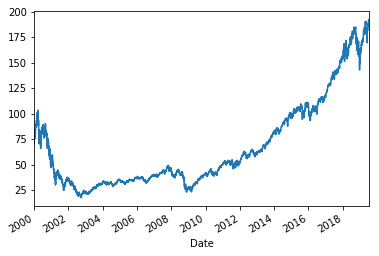

In [6]:
# show plot
df['Adj Close'].plot()
plt.show()

#### 20, 50, 200-day moving avereage

In [7]:
df['20d'] = df['Adj Close'].rolling(window=20, min_periods=0, center = False).mean()
df['50d'] = df['Adj Close'].rolling(window=50, min_periods=0, center = False).mean()
df['200d'] = df['Adj Close'].rolling(window=200, min_periods=0, center = False).mean()

df.dropna(inplace=True)
df.tail()

,High,Low,Open,Close,Volume,Adj Close,20d,50d,200d
Date,,,,,,,,,
2019-07-03,191.440002,190.289993,190.490005,191.440002,15792100.0,191.440002,185.311916,183.605508,173.727275
2019-07-05,191.399994,189.389999,190.130005,191.050003,21415600.0,191.050003,186.003507,183.640678,173.783662
2019-07-08,189.869995,188.929993,189.809998,189.710007,17598800.0,189.710007,186.456977,183.633683,173.825915
2019-07-09,190.899994,188.649994,188.809998,190.660004,19156000.0,190.660004,186.852679,183.642295,173.873611
2019-07-10,193.089996,191.476196,191.789993,192.520004,16884166.0,192.520004,187.328910,183.680723,173.920595


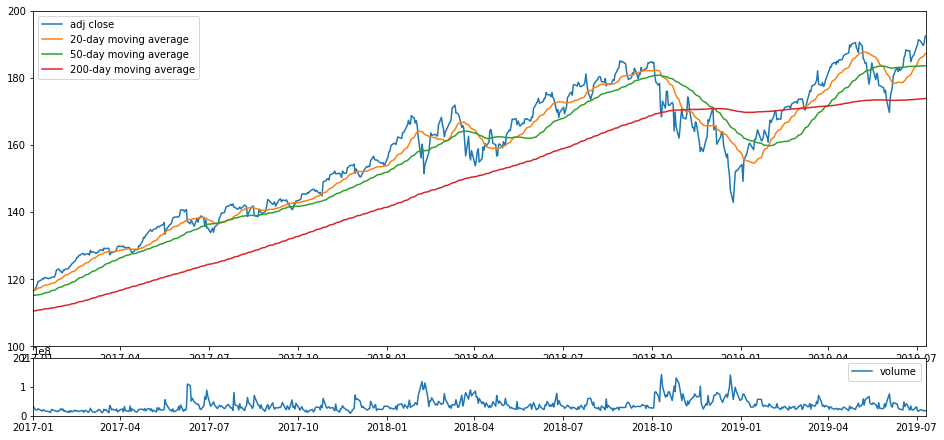

In [43]:
#plot
plt.figure(figsize=(16,10))
ax1 = plt.subplot2grid((8,1), (0,0), rowspan=5, colspan=1) 
ax2 = plt.subplot2grid((8,1), (5,0), rowspan=1, colspan=1, sharex=ax1) 
ax1.plot(df.index, df['Adj Close'], label='adj close')
ax1.plot(df.index, df['20d'], label='20-day moving average')
ax1.plot(df.index, df['50d'], label='50-day moving average')
ax1.plot(df.index, df['200d'], label='200-day moving average')
ax2.plot(df.index, df['Volume'], label='volume')

# set xlim
start_date1 = dt.datetime(2017, 1, 1)
end_date = dt.datetime.now()
ax1.set_xlim([start_date1, end_date ])
ax2.set_xlim([start_date1, end_date ])
ax1.set_ylim([100, 200])
ax2.set_ylim([0, 0.2e9])

ax1.legend();ax2.legend()
plt.show()

#### Trading strategy

*Set regime:*
- if the 20 day average is above the 50 day average --> a bullish regime
- if the 20 day average is below the 50 day average --> a bearish regime


In [15]:
df['20d-50d'] = df['20d'] - df['50d']
df.tail()

,High,Low,Open,Close,Volume,Adj Close,20d,50d,200d,20d-50d
Date,,,,,,,,,,
2019-07-03,191.440002,190.289993,190.490005,191.440002,15792100.0,191.440002,185.311916,183.605508,173.727275,1.706407
2019-07-05,191.399994,189.389999,190.130005,191.050003,21415600.0,191.050003,186.003507,183.640678,173.783662,2.362829
2019-07-08,189.869995,188.929993,189.809998,189.710007,17598800.0,189.710007,186.456977,183.633683,173.825915,2.823294
2019-07-09,190.899994,188.649994,188.809998,190.660004,19156000.0,190.660004,186.852679,183.642295,173.873611,3.210385
2019-07-10,193.089996,191.476196,191.789993,192.520004,16884166.0,192.520004,187.328910,183.680723,173.920595,3.648187


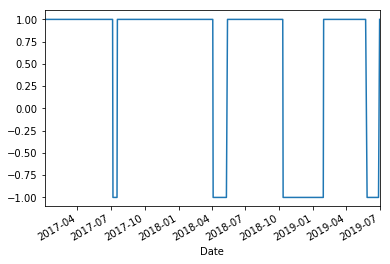

In [89]:

df["Regime"] = np.where(df['20d-50d'] > 0, 1, 0)  # bullish regime = 1
df["Regime"] = np.where(df['20d-50d'] < 0, -1, df["Regime"]) # bearish regime = -1

df.loc['2017-01-01':'2019-07-01','Regime'].plot()

In [30]:
print('Bullish regime = {}%'.format(df['Regime'][df["Regime"]==1].count()/len(df)*100))
print('Bearish regime = {}%'.format(df['Regime'][df["Regime"]==-1].count()/len(df)*100))

Bullish regime = 63.07535641547861%
Bearish regime = 36.51731160896131%


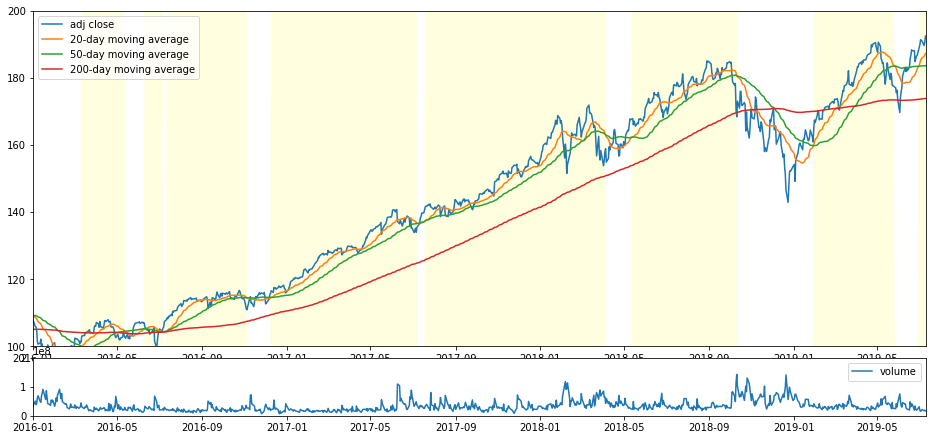

In [48]:
#plot (including bullish vs bearish regime)

plt.figure(figsize=(16,10))
ax1 = plt.subplot2grid((8,1), (0,0), rowspan=5, colspan=1) 
ax2 = plt.subplot2grid((8,1), (5,0), rowspan=1, colspan=1, sharex=ax1) 
ax1.plot(df.index, df['Adj Close'], label='adj close')
ax1.plot(df.index, df['20d'], label='20-day moving average')
ax1.plot(df.index, df['50d'], label='50-day moving average')
ax1.plot(df.index, df['200d'], label='200-day moving average')

# yellow --> bullish regime
ax1.fill_between(df.index, df['Regime']*100+100, color='lightyellow')
ax2.plot(df.index, df['Volume'], label='volume')

# set xlim
start_date1 = dt.datetime(2016, 1, 1)
end_date = dt.datetime.now()
ax1.set_xlim([start_date1, end_date ])
ax2.set_xlim([start_date1, end_date ])
ax1.set_ylim([100, 200])
ax2.set_ylim([0, 0.2e9])


ax1.legend();ax2.legend()
plt.show()

The bullish regime : yellow. The bearish regime: white:
- Stock price moving from yellow to white gives a sell signal
- Stock price moving from white to yellow gives a buy signal

#### Trading signal
Cross-over between bullish and bearish

- bullish --> bearish  : sell signal
- bearish --> bullish : buy signal


In [54]:
# only show the sign of difference


df["Signal"] = np.sign(df["Regime"] - df["Regime"].shift(1))

df.tail()

,High,Low,Open,Close,Volume,Adj Close,20d,50d,200d,20d-50d,Regime,Signal
Date,,,,,,,,,,,,
2019-07-03,191.440002,190.289993,190.490005,191.440002,15792100.0,191.440002,185.311916,183.605508,173.727275,1.706407,1,0.0
2019-07-05,191.399994,189.389999,190.130005,191.050003,21415600.0,191.050003,186.003507,183.640678,173.783662,2.362829,1,0.0
2019-07-08,189.869995,188.929993,189.809998,189.710007,17598800.0,189.710007,186.456977,183.633683,173.825915,2.823294,1,0.0
2019-07-09,190.899994,188.649994,188.809998,190.660004,19156000.0,190.660004,186.852679,183.642295,173.873611,3.210385,1,0.0
2019-07-10,193.089996,191.476196,191.789993,192.520004,16884166.0,192.520004,187.328910,183.680723,173.920595,3.648187,1,0.0


signal: buy=1, sell= -1, hold =0.

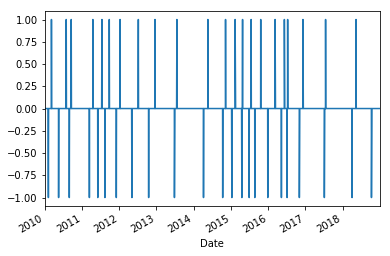

In [92]:
df.loc['2010-01-01':'2018-12-31','Signal'].plot()

In [60]:
#when to sell
df[df['Signal']==1].index

DatetimeIndex(['2000-02-03', '2000-06-20', '2000-08-31', '2001-02-06',
               '2001-05-04', '2001-10-31', '2002-03-28', '2002-09-09',
               '2002-10-31', '2003-03-20', '2003-12-19', '2004-04-21',
               '2004-06-16', '2004-09-15', '2005-05-24', '2005-11-10',
               '2006-04-03', '2006-08-25', '2007-04-11', '2007-09-18',
               '2008-04-07', '2008-08-19', '2009-01-05', '2009-04-02',
               '2010-03-10', '2010-08-02', '2010-09-20', '2011-04-20',
               '2011-07-18', '2011-09-28', '2012-01-12', '2012-07-09',
               '2012-12-19', '2013-07-22', '2014-05-22', '2014-11-11',
               '2015-02-13', '2015-04-27', '2015-07-20', '2015-10-22',
               '2016-03-11', '2016-06-10', '2016-07-12', '2016-12-09',
               '2017-07-19', '2018-05-14', '2019-01-30', '2019-07-01'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [62]:
#when to buy
df[df['Signal']==-1].index

DatetimeIndex(['2000-02-01', '2000-04-14', '2000-08-10', '2000-09-28',
               '2001-02-15', '2001-06-20', '2002-01-24', '2002-04-08',
               '2002-09-17', '2002-12-31', '2003-12-11', '2004-02-26',
               '2004-05-12', '2004-07-22', '2005-01-20', '2005-09-13',
               '2006-02-10', '2006-05-17', '2007-03-08', '2007-08-16',
               '2007-11-23', '2008-06-27', '2008-09-12', '2009-02-26',
               '2010-02-08', '2010-05-19', '2010-09-01', '2011-03-17',
               '2011-06-07', '2011-08-16', '2011-12-06', '2012-05-07',
               '2012-10-18', '2013-06-28', '2014-04-09', '2014-10-14',
               '2015-01-12', '2015-04-20', '2015-07-01', '2015-08-25',
               '2015-12-30', '2016-05-12', '2016-07-07', '2016-11-04',
               '2017-07-07', '2018-04-05', '2018-10-12', '2019-05-28'],
              dtype='datetime64[ns]', name='Date', freq=None)

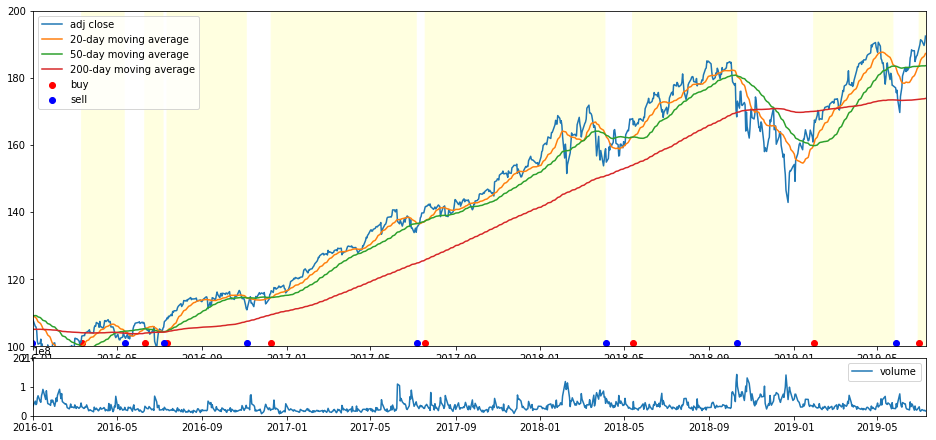

In [93]:
#plot (including bullish vs bearish regime)

plt.figure(figsize=(16,10))
ax1 = plt.subplot2grid((8,1), (0,0), rowspan=5, colspan=1) 
ax2 = plt.subplot2grid((8,1), (5,0), rowspan=1, colspan=1, sharex=ax1) 
ax1.plot(df.index, df['Adj Close'], label='adj close')
ax1.plot(df.index, df['20d'], label='20-day moving average')
ax1.plot(df.index, df['50d'], label='50-day moving average')
ax1.plot(df.index, df['200d'], label='200-day moving average')


# lightyellow --> bullish regime
ax1.fill_between(df.index, df['Regime']*100+100, color='lightyellow')
ax1.scatter(df[df['Signal']==1].index, df[df['Signal']==1]['Signal']*1+100, color='red', label='buy')
ax1.scatter(df[df['Signal']==-1].index, df[df['Signal']==-1]['Signal']*(-1)+100, color='blue', label='sell')

ax2.plot(df.index, df['Volume'], label='volume')


# set xlim
start_date1 = dt.datetime(2016, 1, 1)
end_date = dt.datetime.now()
ax1.set_xlim([start_date1, end_date ])
ax2.set_xlim([start_date1, end_date ])
ax1.set_ylim([100, 200])
ax2.set_ylim([0, 0.2e9])


ax1.legend();ax2.legend()
plt.show()

Suggested next steps:
- Use the moving average curve for long-term and short-term investment (high freqency or low frequency traders ?)
-  how to incorporate this into LSTM model?

